In [1]:
import os
import glob
import time

import pandas as pd
import numpy as np
import xarray as xr
import datetime


import matplotlib
from matplotlib import pyplot as plt
from matplotlib.ticker import NullFormatter
%matplotlib inline
matplotlib.rcParams.update({'font.size': 16})

import cartopy.crs as ccrs
import cartopy

import sys
p = '/global/homes/q/qnicolas'
if p not in sys.path:
    sys.path.append(p)

from orographicPrecipitation.wrfProcessing.wrf_hr_utils import *
#from orographicPrecipitation.wrfProcessing.wrfProcessing import *


#from orographicPrecipitation.precip_model_functions import qsat,humidsat
from orographicConvectionTheory.orographicConvectionTheory import *
from orographicPrecipitation.observationsAndERA5.mountainUtils import compute_N

SCRATCH='/global/cscratch1/sd/qnicolas/'

import dask
import dask.dataframe


In [3]:
dask.config.config["distributed"]["dashboard"]["link"] = "{JUPYTERHUB_SERVICE_PREFIX}proxy/{port}/status"
from dask.distributed import Client
client=Client()
client

/global/homes/q/qnicolas/.conda/envs/era5/lib/python3.7/site-packages/distributed/node.py:155: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 44307 instead
  http_address["port"], self.http_server.port


Client Scheduler: tcp://127.0.0.1:46623 Dashboard: /user/qnicolas/perlmutter-shared-node-cpu/proxy/44307/status,Cluster Workers: 16 Cores: 256 Memory: 540.25 GB


In [4]:
xr.set_options(display_style='text') 

# Data, functions

In [5]:
def subtract_background(var):
    return var - var.sel(distance_from_mtn=slice(-2500,-4000)).mean('distance_from_mtn')

In [6]:
class Simulation():
    def __init__(self,path,center,dx,data_type='wrfout',suffix='days1-200'):
        self.center = center
        self.dx = dx
        self.path=path
        self.input = xr.open_dataset(path+'wrfinput_d01')
        
        self.RAINNC_HOURLY      = xr.open_zarr(self.path +'diags/wrf.RAINNC_HOURLY.%s.zarr'%suffix).RAINNC
        
        self.data = extract_wrfout(path)
        self.datapl = extract_wrfpro(path)
        
        
W10S300 = Simulation('/pscratch/sd/q/qnicolas/wrfdata/channel.wrf.100x2.mountain.60lev.500m.3km/',1635,3)
W10S296 = Simulation('/pscratch/sd/q/qnicolas/wrfdata/channel.wrf.100x2.mountain.60lev.500m.296K.3km/',1635,3,suffix='days1-253')



In [7]:
W10S300.label="10m/s, 300K"
#W12S300.label="12m/s, 300K"
W10S296.label="10m/s, 296K"

In [8]:
W10S300.color='g'
#W12S300.color='lime'
W10S296.color='b'

In [9]:
W10S300.RAINNC_HOURLY = change_coords_sfc(W10S300.RAINNC_HOURLY)
#W12S300.RAINNC_HOURLY = change_coords_sfc(W12S300.RAINNC_HOURLY)
W10S296.RAINNC_HOURLY = change_coords_sfc(W10S296.RAINNC_HOURLY)

In [10]:
plevs_ref = np.arange(125.,990.,10.)
zlevs_ref = np.arange(0.,20000.,150.)

In [11]:
W10S300.THETA = xr.open_dataarray(W10S300.path+'diags/wrf.THETA.days50-200.nc')
W10S300.THETA = change_coords_eta(W10S300.input,W10S300.THETA)
W10S300.THETA_P = interp_eta_to_pressure(W10S300.data,W10S300.THETA,0,dsinput=W10S300.input)
W10S300.TEMP_P = W10S300.THETA_P*(W10S300.THETA_P.pressure/1e3)**0.286

W10S296.TEMP = change_coords_eta(W10S296.input,xr.open_dataarray(W10S296.path+'diags/wrf.TEMP.days50-254.nc'))
W10S296.TEMP_P = interp_eta_to_pressure(W10S296.data,W10S296.TEMP,0,dsinput=W10S296.input,plevs=plevs_ref)

In [12]:
W10S300.PTOT = change_coords_eta(W10S300.input,(W10S300.input.PB[0,:,0]+W10S300.data.P[-200:].mean(['Time','south_north'])).load())
W10S300.TEMP = W10S300.THETA*(W10S300.PTOT/1e5)**0.286

In [13]:
W10S300.TEMP_Z = interp_eta_to_z(W10S300.data,W10S300.TEMP,0,dsinput=W10S300.input,zlevs=zlevs_ref)
W10S296.TEMP_Z = interp_eta_to_z(W10S296.data,W10S296.TEMP,0,dsinput=W10S296.input,zlevs=zlevs_ref)

In [14]:
W10S300.QVAPOR = change_coords_eta(W10S300.input,xr.open_dataarray(W10S300.path+'diags/wrf.QVAPOR.days50-200.nc'))
W10S300.QVAPOR_P = interp_eta_to_pressure(W10S300.data,W10S300.QVAPOR,0,dsinput=W10S300.input,plevs=plevs_ref)

W10S296.QVAPOR = change_coords_eta(W10S296.input,xr.open_dataarray(W10S296.path+'diags/wrf.QVAPOR.days50-254.nc'))
W10S296.QVAPOR_P = interp_eta_to_pressure(W10S296.data,W10S296.QVAPOR,0,dsinput=W10S296.input,plevs=plevs_ref)

In [15]:
W10S300.QVAPOR_Z = interp_eta_to_z(W10S300.data,W10S300.QVAPOR,0,dsinput=W10S300.input,zlevs=zlevs_ref)
W10S296.QVAPOR_Z = interp_eta_to_z(W10S296.data,W10S296.QVAPOR,0,dsinput=W10S296.input,zlevs=zlevs_ref)

In [16]:
W10S300.W = change_coords_eta(W10S300.input,xr.open_dataarray(W10S300.path+'diags/wrf.W.days50-200.nc'),staggered=True)
W10S300.W_P = interp_eta_to_pressure(W10S300.data,W10S300.W,1,dsinput=W10S300.input,plevs=plevs_ref)

W10S296.W = change_coords_eta(W10S296.input,xr.open_dataarray(W10S296.path+'diags/wrf.W.days50-254.nc'),staggered=True)
W10S296.W_P = interp_eta_to_pressure(W10S296.data,W10S296.W,1,dsinput=W10S296.input,plevs=plevs_ref)

In [17]:
W10S300.W_Z = interp_eta_to_z(W10S300.data,W10S300.W,1,dsinput=W10S300.input,zlevs=zlevs_ref)
W10S296.W_Z = interp_eta_to_z(W10S296.data,W10S296.W,1,dsinput=W10S296.input,zlevs=zlevs_ref)

In [18]:
W10S300.N_P = compute_N(W10S300.TEMP_P,100)
W10S296.N_P = compute_N(W10S296.TEMP_P,100)

# Stability

Fractional change (900-700hPa mean): 1.43 %/K
Fractional change (900-200hPa mean): 2.32 %/K


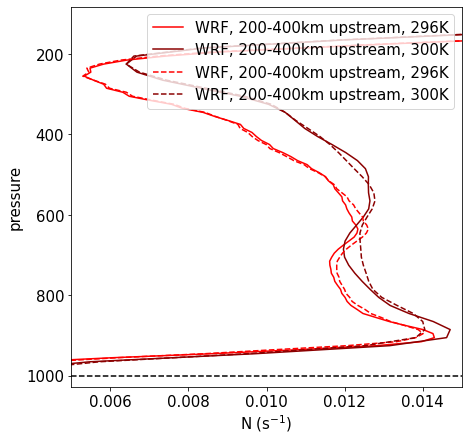

In [32]:
fig,ax = plt.subplots(1,1,figsize=(7,7))
N296Kupstream = W10S296.N_P.sel(distance_from_mtn=slice(-2000,-4000)).mean('distance_from_mtn')
N300Kupstream = W10S300.N_P.sel(distance_from_mtn=slice(-2000,-4000)).mean('distance_from_mtn')
N296Kabove = W10S296.N_P.sel(distance_from_mtn=slice(-100,-200)).mean('distance_from_mtn')
N300Kabove = W10S300.N_P.sel(distance_from_mtn=slice(-100,-200)).mean('distance_from_mtn')

N296Kupstream.plot(ax=ax,y='pressure',yincrease=False,color='red',label='WRF, 200-400km upstream, 296K')
N300Kupstream.plot(ax=ax,y='pressure',yincrease=False,color='darkred'    ,label='WRF, 200-400km upstream, 300K')
N296Kabove.plot(ax=ax,y='pressure',yincrease=False,linestyle='--',color='red',label='WRF, 200-400km upstream, 296K')
N300Kabove.plot(ax=ax,y='pressure',yincrease=False,linestyle='--',color='darkred'    ,label='WRF, 200-400km upstream, 300K')

ax.set_xlabel(r"N (s$^{-1})$")
ax.axvline(0.,color='k',linestyle='--')
ax.axhline(1000.,color='k',linestyle='--')
ax.legend()
ax.set_xlim(0.005,0.015)

print("Fractional change (900-700hPa mean): %.2f %%/K"%((N300Kupstream.sel(pressure=slice(900,700)).mean()/N296Kupstream.sel(pressure=slice(900,700)).mean()-1)*100/4))
print("Fractional change (900-200hPa mean): %.2f %%/K"%((N300Kupstream.sel(pressure=slice(900,200)).mean()/N296Kupstream.sel(pressure=slice(900,200)).mean()-1)*100/4))


# Temperature

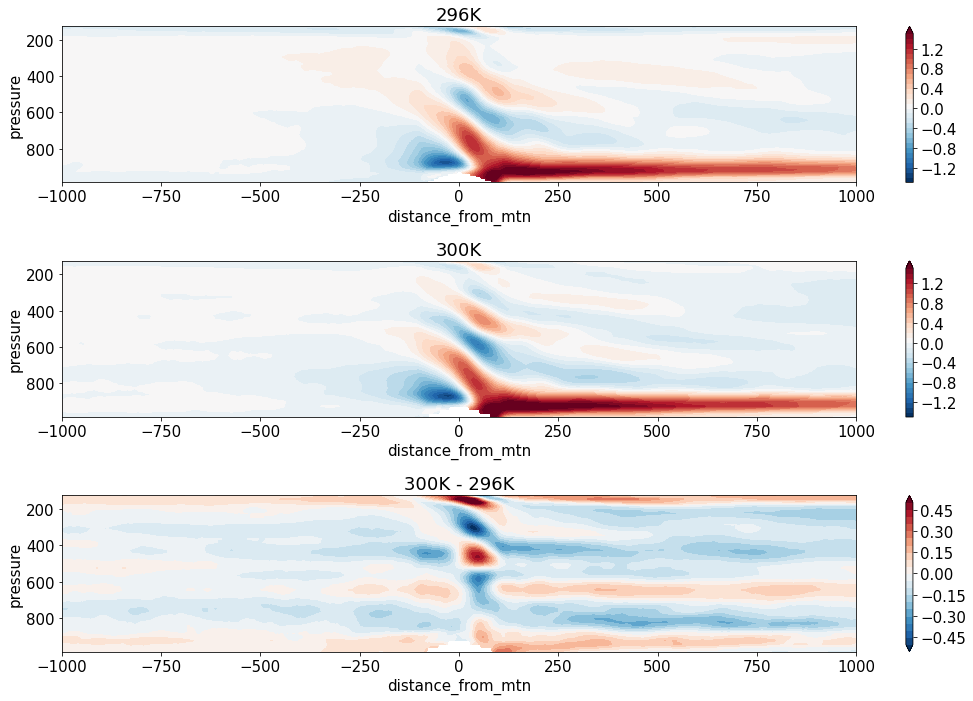

In [34]:
fig,(ax1,ax2,ax3)=plt.subplots(3,1,figsize=(15,10))
lvls = np.arange(-1.5,1.6,0.1)

subtract_background(W10S296.TEMP_P).plot.contourf(ax=ax1,yincrease=False,levels=lvls)
ax1.set_title("296K")

subtract_background(W10S300.TEMP_P).plot.contourf(ax=ax2,yincrease=False,levels=lvls)
ax2.set_title("300K")

(subtract_background(W10S300.TEMP_P)-subtract_background(W10S296.TEMP_P)).plot.contourf(ax=ax3,yincrease=False,levels=np.arange(-0.5,0.501,0.05))
ax3.set_title("300K - 296K")


for ax in (ax1,ax2,ax3):
    ax.set_xlim(-1000,1000)
fig.tight_layout()

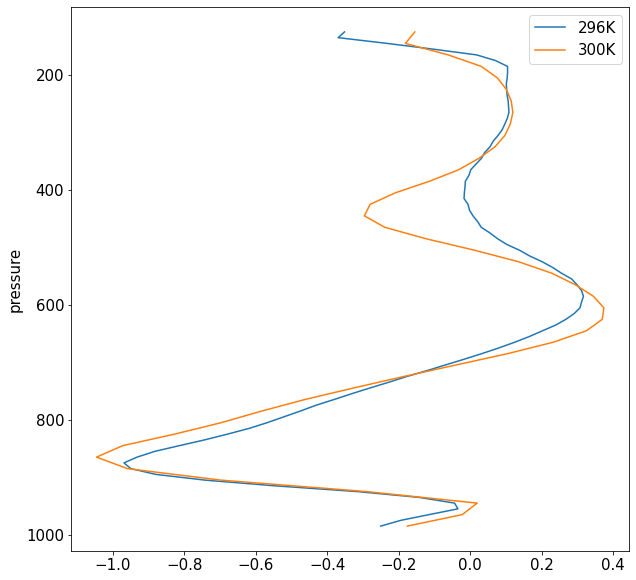

In [35]:
fig,ax=plt.subplots(1,1,figsize=(10,10))

subtract_background(W10S296.TEMP_P).sel(distance_from_mtn=slice(-50,-100)).mean('distance_from_mtn').plot(ax=ax,y='pressure',yincrease=False,label='296K')
subtract_background(W10S300.TEMP_P).sel(distance_from_mtn=slice(-50,-100)).mean('distance_from_mtn').plot(ax=ax,y='pressure',yincrease=False,label='300K')

ax.legend()

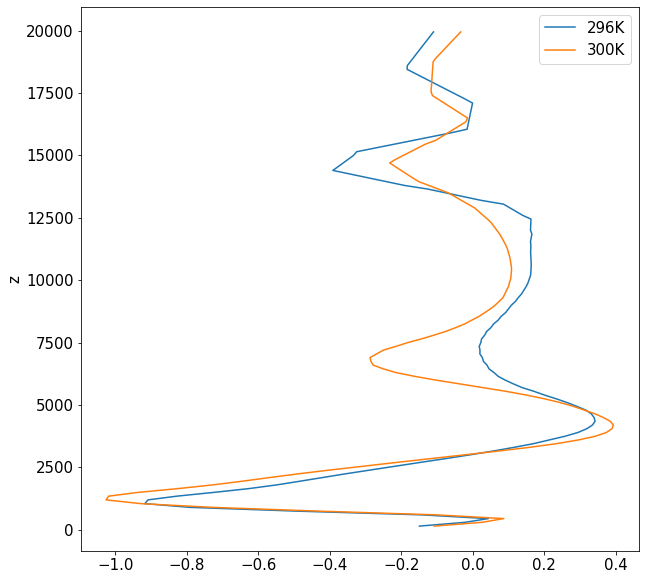

In [19]:
fig,ax=plt.subplots(1,1,figsize=(10,10))

subtract_background(W10S296.TEMP_Z).sel(distance_from_mtn=slice(-50,-100)).mean('distance_from_mtn').plot(ax=ax,y='z',label='296K')
subtract_background(W10S300.TEMP_Z).sel(distance_from_mtn=slice(-50,-100)).mean('distance_from_mtn').plot(ax=ax,y='z',label='300K')

ax.legend()

In [19]:
print(1)

1


In [183]:
Tprime296_above = subtract_background(W10S296.TEMP_Z).sel(distance_from_mtn=slice(-50,-100)).mean('distance_from_mtn')[1:101]
Tprime300_above = subtract_background(W10S300.TEMP_Z).sel(distance_from_mtn=slice(-50,-100)).mean('distance_from_mtn')[1:101]

Tprime296_above_ft = np.fft.rfft(Tprime296_above)
Tprime300_above_ft = np.fft.rfft(Tprime300_above)


In [36]:
ms = np.fft.rfftfreq(len(Tprime296_above),float(Tprime296_above.z[1]-Tprime296_above.z[0]))

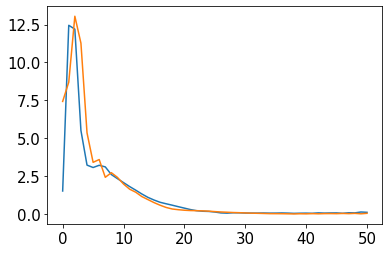

In [37]:
plt.plot(np.abs(Tprime296_above_ft))
plt.plot(np.abs(Tprime300_above_ft))

In [38]:
mmean_296 = np.sum(np.abs(Tprime296_above_ft)*ms)/np.sum(np.abs(Tprime296_above_ft))
mmean_300 = np.sum(np.abs(Tprime300_above_ft)*ms)/np.sum(np.abs(Tprime300_above_ft))


In [39]:
mmean_300/mmean_296

0.804661135988927

In [40]:
((mmean_300/mmean_296)-1)*100/4

-4.883471600276826

# W

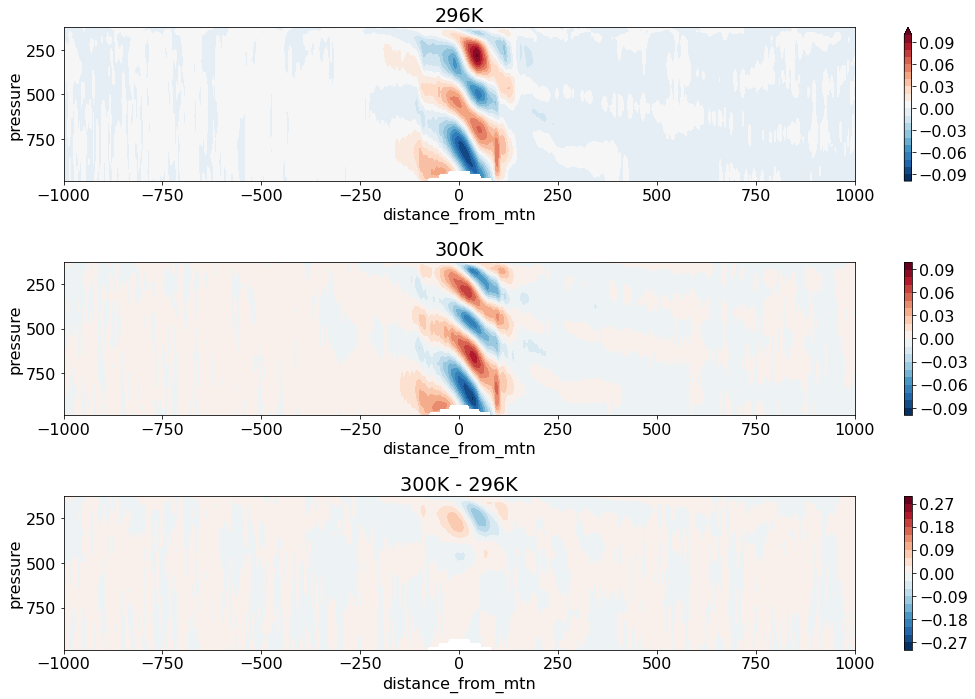

In [38]:
fig,(ax1,ax2,ax3)=plt.subplots(3,1,figsize=(15,10))
lvls = np.linspace(-0.1,0.1,21)

subtract_background(W10S296.W_P).plot.contourf(ax=ax1,yincrease=False,levels=lvls)
ax1.set_title("296K")

subtract_background(W10S300.W_P).plot.contourf(ax=ax2,yincrease=False,levels=lvls)
ax2.set_title("300K")

(subtract_background(W10S300.W_P)-subtract_background(W10S296.W_P)).plot.contourf(ax=ax3,yincrease=False,levels=np.linspace(-0.3,0.3,21))
ax3.set_title("300K - 296K")


for ax in (ax1,ax2,ax3):
    ax.set_xlim(-1000,1000)
fig.tight_layout()

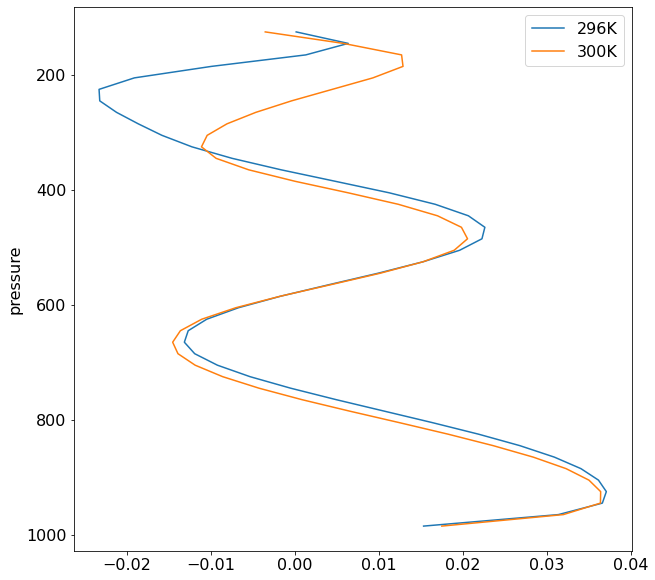

In [36]:
fig,ax=plt.subplots(1,1,figsize=(10,10))

subtract_background(W10S296.W_P).sel(distance_from_mtn=slice(-50,-100)).mean('distance_from_mtn').plot(ax=ax,y='pressure',yincrease=False,label='296K')
subtract_background(W10S300.W_P).sel(distance_from_mtn=slice(-50,-100)).mean('distance_from_mtn').plot(ax=ax,y='pressure',yincrease=False,label='300K')

ax.legend()

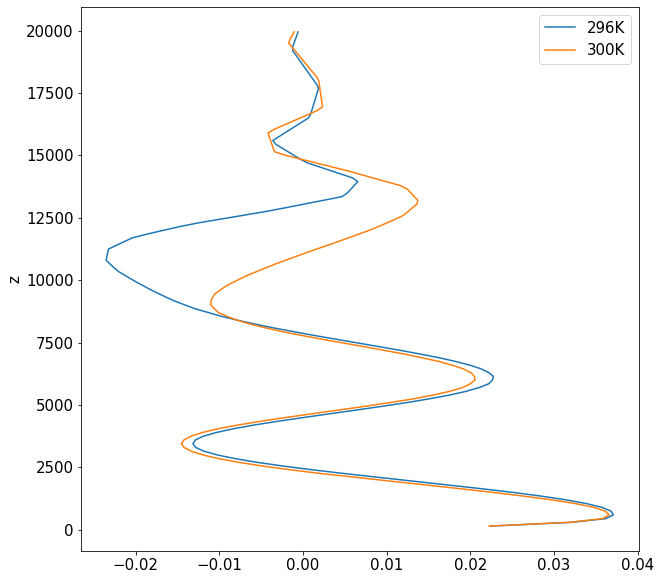

In [57]:
fig,ax=plt.subplots(1,1,figsize=(10,10))

subtract_background(W10S296.W_Z).sel(distance_from_mtn=slice(-50,-100)).mean('distance_from_mtn').plot(ax=ax,y='z',label='296K')
subtract_background(W10S300.W_Z).sel(distance_from_mtn=slice(-50,-100)).mean('distance_from_mtn').plot(ax=ax,y='z',label='300K')

ax.legend()

In [216]:
wprime296_above = subtract_background(W10S296.W_Z).sel(distance_from_mtn=slice(-50,-100)).mean('distance_from_mtn')[1:]
wprime300_above = subtract_background(W10S300.W_Z).sel(distance_from_mtn=slice(-50,-100)).mean('distance_from_mtn')[1:]

wprime296_above_ft = np.fft.rfft(wprime296_above)
wprime300_above_ft = np.fft.rfft(wprime300_above)


In [217]:
ms = np.fft.rfftfreq(len(wprime296_above),float(wprime296_above.z[1]-wprime296_above.z[0]))

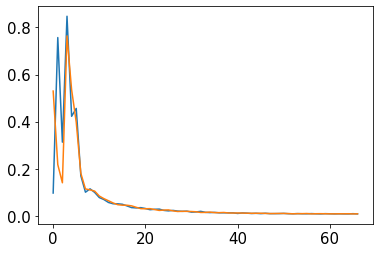

In [218]:
plt.plot(np.abs(wprime296_above_ft))
plt.plot(np.abs(wprime300_above_ft))

In [219]:
mmean_296 = np.sum(np.abs(wprime296_above_ft)*ms)/np.sum(np.abs(wprime296_above_ft))
mmean_300 = np.sum(np.abs(wprime300_above_ft)*ms)/np.sum(np.abs(wprime300_above_ft))


In [220]:
mmean_300/mmean_296

1.052993468662719

In [221]:
((mmean_300/mmean_296)-1)*100/4

1.324836716567973

# Q

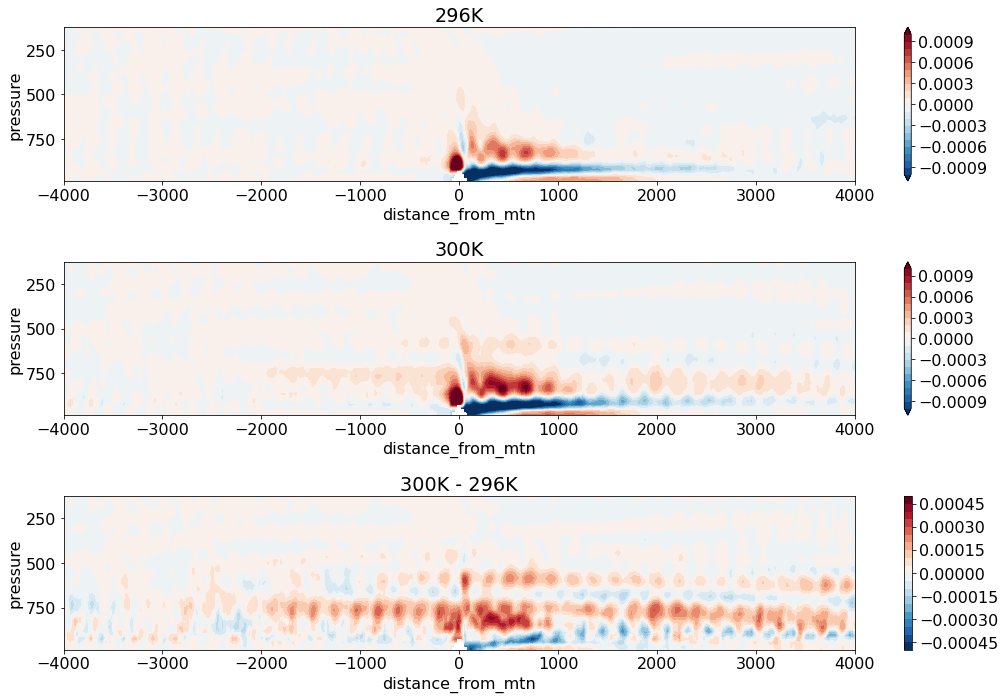

In [45]:
fig,(ax1,ax2,ax3)=plt.subplots(3,1,figsize=(15,10))
lvls = np.linspace(-0.001,0.001,21)

subtract_background(W10S296.QVAPOR_P).plot.contourf(ax=ax1,yincrease=False,levels=lvls)
ax1.set_title("296K")

subtract_background(W10S300.QVAPOR_P).plot.contourf(ax=ax2,yincrease=False,levels=lvls)
ax2.set_title("300K")

(subtract_background(W10S300.QVAPOR_P)-subtract_background(W10S296.QVAPOR_P)).plot.contourf(ax=ax3,yincrease=False,levels=np.linspace(-0.0005,0.0005,21))
ax3.set_title("300K - 296K")


for ax in (ax1,ax2,ax3):
    ax.set_xlim(-4000,4000)
fig.tight_layout()

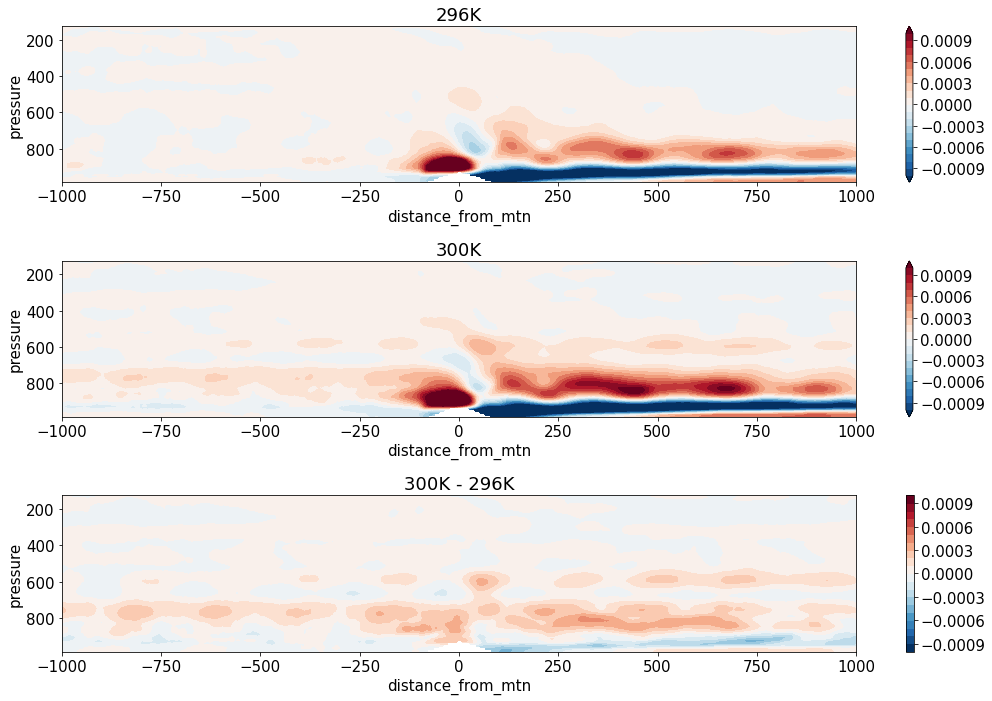

In [298]:
fig,(ax1,ax2,ax3)=plt.subplots(3,1,figsize=(15,10))
lvls = np.linspace(-0.001,0.001,21)

subtract_background(W10S296.QVAPOR_P).plot.contourf(ax=ax1,yincrease=False,levels=lvls)
ax1.set_title("296K")

subtract_background(W10S300.QVAPOR_P).plot.contourf(ax=ax2,yincrease=False,levels=lvls)
ax2.set_title("300K")

(subtract_background(W10S300.QVAPOR_P)-subtract_background(W10S296.QVAPOR_P)).plot.contourf(ax=ax3,yincrease=False,levels=lvls)
ax3.set_title("300K - 296K")


for ax in (ax1,ax2,ax3):
    ax.set_xlim(-1000,1000)
fig.tight_layout()

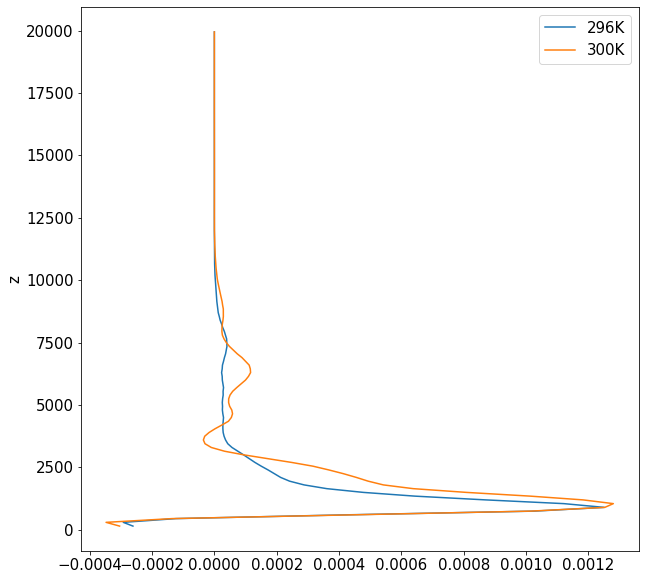

In [301]:
fig,ax=plt.subplots(1,1,figsize=(10,10))

subtract_background(W10S296.QVAPOR_Z).sel(distance_from_mtn=slice(-50,-100)).mean('distance_from_mtn').plot(ax=ax,y='z',label='296K')
subtract_background(W10S300.QVAPOR_Z).sel(distance_from_mtn=slice(-50,-100)).mean('distance_from_mtn').plot(ax=ax,y='z',label='300K')

ax.legend()

In [302]:
qprime296_above = subtract_background(W10S296.QVAPOR_Z).sel(distance_from_mtn=slice(-50,-100)).mean('distance_from_mtn')[1:]
qprime300_above = subtract_background(W10S300.QVAPOR_Z).sel(distance_from_mtn=slice(-50,-100)).mean('distance_from_mtn')[1:]


# Wavelet analysis

In [290]:
import pycwt

def cwt(da):
    dat=np.array(da)
    z = np.array(da.z)
    dat = dat-dat.mean()
    
    std = np.std(dat)
    dat_norm = dat / std  # Normalized dataset
    #The next step is to define some parameters of our wavelet analysis. We select the mother wavelet, in this case the Morlet wavelet with ω0=6.
    
    mother = pycwt.Morlet(6)
    dz=z[1]-z[0]
    
    #The following routines perform the wavelet transform and inverse wavelet transform using the parameters defined above. Since we have normalized our input time-series, we multiply the inverse transform by the standard deviation.
    wave, scales, freqs, coi, fft, fftfreqs = pycwt.cwt(dat_norm, dz,dj=0.01,wavelet=mother)
    return wave, scales, freqs, coi, fft, fftfreqs

def global_power(da):
    wave, scales, freqs, coi, fft, fftfreqs = cwt(da)
    wavelength = 1 / freqs
    power = (np.abs(wave)) ** 2
    glbl_power=power.mean(axis=1)
    return wavelength,glbl_power
    
def plot_cwt(da,plotcoi=False):
    dat=np.array(da)
    z = np.array(da.z)
    dat = dat-dat.mean()
    std = np.std(dat);var=std**2
    
    wave, scales, freqs, coi, fft, fftfreqs = cwt(da)
    iwave = pycwt.icwt(wave, scales, dz,dj=0.01,wavelet=mother)*std
    
    power = (np.abs(wave)) ** 2
    fft_power = np.abs(fft) ** 2
    wavelength = 1 / freqs
    #Optionally, we could also rectify the power spectrum according to the suggestions proposed by Liu et al. (2007)[2]
    #power /= scales[:, None]
    glbl_power=power.mean(axis=1)
    
    fig = plt.figure(figsize=(11, 8))
    # First sub-plot, the original time series anomaly and inverse wavelet transform.
    ax = plt.axes([0.1, 0.75, 0.65, 0.2])
    ax.plot(z, np.real(iwave)*150, '-', linewidth=1, color=[0.5, 0.5, 0.5])
    ax.plot(z, dat, 'k', linewidth=1.5)
    
    # Second sub-plot, the normalized wavelet power spectrum and cone of influece hatched area
    bx = plt.axes([0.1, 0.37, 0.65, 0.28], sharex=ax)
    #levels = np.sort(0.005*1/2**np.arange(10))
    levels = np.linspace(0.,40.,11)
    cf = bx.contourf(z, wavelength, power, levels, extend='both', cmap=plt.cm.viridis)

    if plotcoi:
        bx.fill(np.concatenate([z, z[-1:] + dz, z[-1:] + dz,
                                   z[:1] - dz, z[:1] - dz]),
                np.concatenate([coi, [1e-9], wavelength[-1:],
                                   wavelength[-1:], [1e-9]]),
                'k', alpha=0.3, hatch='x')
    # colorbar
    cax = fig.add_axes([0.2,0.2,0.4,0.05])
    cb=plt.colorbar(cf,ax=ax,cax=cax,orientation='horizontal')#,location='bottom'
    cb.ax.tick_params(labelsize=15)
    
    
    # Third sub-plot, the global wavelet and Fourier power spectra and theoretical noise spectra
    cx = plt.axes([0.77, 0.37, 0.2, 0.28], sharey=bx)
    cx.plot(var * fft_power, 1./fftfreqs, '-', color='#cccccc',
            linewidth=1.)
    cx.plot(var * glbl_power, wavelength, 'k-', linewidth=1.5)
    #cx.set_title('c) Global Wavelet Spectrum')
    #cx.set_xlim([0, glbl_power.max() + var])
    cx.set_ylim([wavelength.min(), wavelength.max()])
    plt.setp(cx.get_yticklabels(), visible=False)
    return fig

    
    

## T'

Text(0.5, 0.98, "T' - 296K")

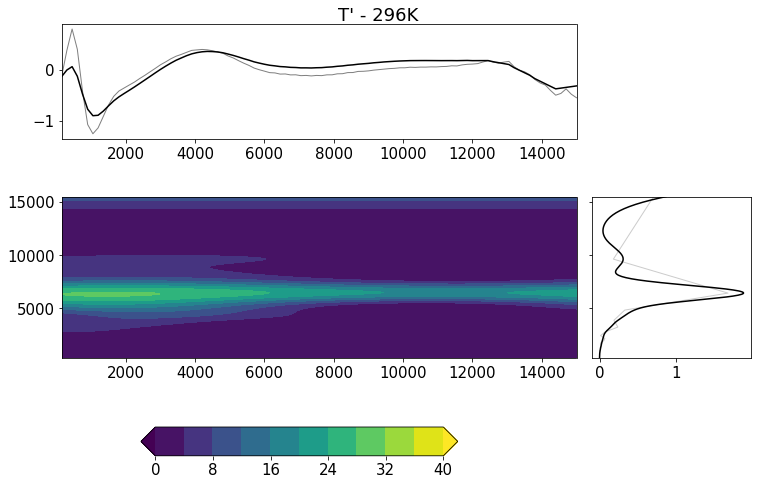

In [286]:
fig = plot_cwt(Tprime296_above)
fig.suptitle("T' - 296K" )

Text(0.5, 0.98, "T' - 300K")

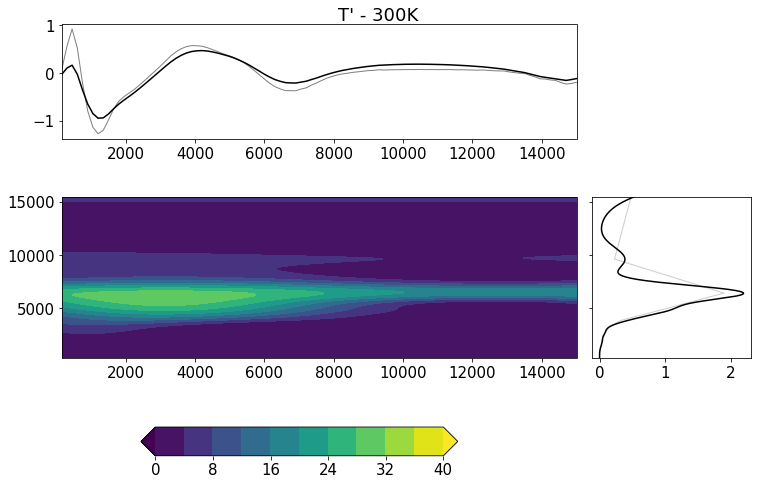

In [287]:
fig = plot_cwt(Tprime300_above)
fig.suptitle("T' - 300K" )

Text(0.5, 0.98, "T' - 300K")

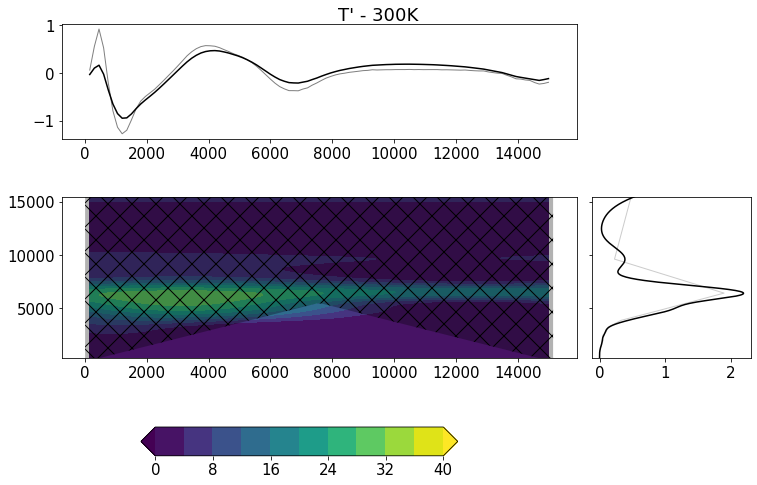

In [288]:
fig = plot_cwt(Tprime300_above,True)
fig.suptitle("T' - 300K" )

Shift in wavenumber (mean of distribution): 3.17 %/K
Shift in wavenumber (mode of distribution): 0.17 %/K


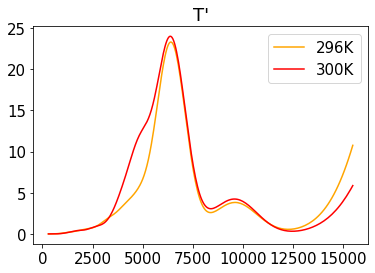

In [295]:
lambdas, power296 = global_power(Tprime296_above)
lambdas, power300 = global_power(Tprime300_above)
ms = 1/lambdas
print("Shift in wavenumber (mean of distribution): %.2f %%/K"%((np.trapz(ms*power300,ms)/np.trapz(ms*power296,ms) -1)*100/4))
print("Shift in wavenumber (mode of distribution): %.2f %%/K"%((ms[power300.argmax()]/ms[power296.argmax()] -1)*100/4))

plt.plot(lambdas, power296, color='orange', linewidth=1.5,label='296K')
plt.plot(lambdas, power300, color='red', linewidth=1.5,label='300K')
plt.title("T'")
plt.legend()

Shift in wavenumber (mean of distribution): 7.29 %/K
Shift in wavenumber (mode of distribution): 55.11 %/K


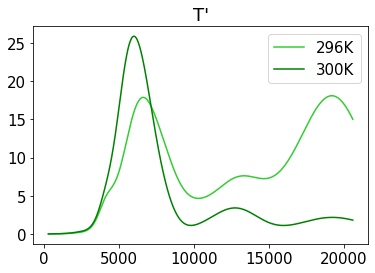

In [296]:
lambdas, power296 = global_power(wprime296_above)
lambdas, power300 = global_power(wprime300_above)
ms = 1/lambdas
print("Shift in wavenumber (mean of distribution): %.2f %%/K"%((np.trapz(ms*power300,ms)/np.trapz(ms*power296,ms) -1)*100/4))
print("Shift in wavenumber (mode of distribution): %.2f %%/K"%((ms[power300.argmax()]/ms[power296.argmax()] -1)*100/4))

plt.plot(lambdas, power296, color='limegreen', linewidth=1.5,label='296K')
plt.plot(lambdas, power300, color='green', linewidth=1.5,label='300K')
plt.title("T'")
plt.legend()

Shift in wavenumber (mean of distribution): -5.96 %/K
Shift in wavenumber (mode of distribution): 0.00 %/K


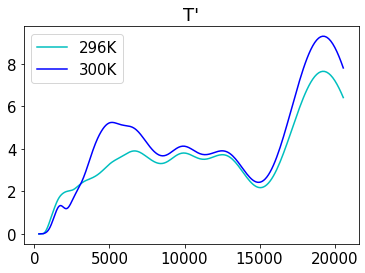

In [308]:
lambdas, power296 = global_power(qprime296_above)
lambdas, power300 = global_power(qprime300_above)
ms = 1/lambdas
print("Shift in wavenumber (mean of distribution): %.2f %%/K"%((np.trapz(ms*power300,ms)/np.trapz(ms*power296,ms) -1)*100/4))
print("Shift in wavenumber (mode of distribution): %.2f %%/K"%((ms[power300.argmax()]/ms[power296.argmax()] -1)*100/4))

plt.plot(lambdas, power296, color='c', linewidth=1.5,label='296K')
plt.plot(lambdas, power300, color='b', linewidth=1.5,label='300K')
plt.title("T'")
plt.legend()

In [21]:
365*3

1095

In [22]:
11*3*50

1650